# Misión "Catálogo Exoplanetario" – Práctica K-Means y clasificación con Árboles y SVM

Bienvenido/a a la **Patrulla de Análisis de Exoplanetas (PAE)**. Formas parte de un equipo de científicos de datos
asignado a la **Estación Orbital Kepler**, donde se reciben continuamente mediciones procedentes de sondas y
telescopios repartidos por toda la galaxia.

Hace unas horas ha llegado un nuevo lote de información desde una patrulla espacial automática. Los astrónomos han
confirmado que se trata de cientos de **exoplanetas**, pero aún no existe una clasificación clara de sus tipos:
gigantes gaseosos, mundos rocosos, super-Tierras, etc. Tu equipo ha sido encargado de **descubrir patrones** en esos
datos y proponer una taxonomía inicial de exoplanetas que después pueda utilizar el resto de la flota.

Para ello, trabajarás con un catálogo de exoplanetas confirmados y tu misión será:

1. **Descubrir tipos de exoplanetas (no supervisado)**  
   - Seleccionar un conjunto de **variables físicas** (masa, radio, periodo orbital, etc.).  
   - Aplicar **K-Means** para agrupar los exoplanetas en varios clusters y analizar qué tipo de mundos aparecen.

2. **Crear una columna de clasificación a partir de K-Means**  
   - Convertir los clusters obtenidos en una **columna de clase** (por ejemplo `tipo_planeta`).  
   - Asignar nombres descriptivos a cada tipo (p. ej. “Gigantes calientes/fríos”, “Super-Tierras”, etc.).

3. **Entrenar modelos supervisados para imitar esa clasificación**  
   - Entrenar un **árbol de decisión** y comparar la **accuracy** en train vs test según la profundidad.  
   - Entrenar tres modelos **SVM** con kernels distintos (`linear`, `poly`, `rbf`) y comparar sus matrices de confusión.

4. **Documentar la misión en un informe**  
   - Redactar un **informe en Word** explicando las decisiones tomadas, los resultados obtenidos y la interpretación
     científica de los tipos de exoplanetas encontrados.

> Tu objetivo final es proponer al **Comité Científico de la Estación Kepler** una primera clasificación fiable de los
> exoplanetas del catálogo, respaldada por análisis de datos y modelos de Machine Learning.


Fuente de datos: https://dataherb.github.io/flora/nasa_exoplanet_archive/


## 1. Carga de librerías y configuración

In [22]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D 

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


## 2. Carga del catálogo de exoplanetas

Puedes descargar el CSV y llamarlo `confirmed_exoplanets.csv` o dejar que el notebook lo lea desde GitHub.


In [23]:
local_filename = "confirmed_exoplanets.csv"
url_backup = "https://raw.githubusercontent.com/InterImm/nasa-exoplanet-archive/master/dataset/confirmed_exoplanets.csv"

try:
    df = pd.read_csv(local_filename)
    origen = f"archivo local: {local_filename}"
except FileNotFoundError:
    print(f"No se ha encontrado `{local_filename}`. Descargando desde la URL...")
    df = pd.read_csv(url_backup)
    origen = "descarga online desde GitHub"

print("Datos cargados desde", origen)
print("Número de filas y columnas:", df.shape)
display(df.head())

No se ha encontrado `confirmed_exoplanets.csv`. Descargando desde la URL...
Datos cargados desde descarga online desde GitHub
Número de filas y columnas: (4126, 72)


,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,...,st_mass,st_masserr1,st_masserr2,st_masslim,st_rad,st_raderr1,st_raderr2,st_radlim,rowupdate,pl_facility
0,11 Com,b,11 Com b,Radial Velocity,0,1,326.03000,0.32,-0.32,0.0,...,2.70,0.30,-0.30,0.0,19.00,2.00,-2.00,0.0,2014-05-14,Xinglong Station
1,11 UMi,b,11 UMi b,Radial Velocity,0,1,516.21997,3.20,-3.20,0.0,...,2.78,0.69,-0.69,0.0,29.79,2.84,-2.84,0.0,2018-09-06,Thueringer Landessternwarte Tautenburg
2,14 And,b,14 And b,Radial Velocity,0,1,185.84000,0.23,-0.23,0.0,...,2.20,0.10,-0.20,0.0,11.00,1.00,-1.00,0.0,2014-05-14,Okayama Astrophysical Observatory
3,14 Her,b,14 Her b,Radial Velocity,0,1,1773.40002,2.50,-2.50,0.0,...,0.90,0.04,-0.04,0.0,0.93,0.01,-0.01,0.0,2018-09-06,W. M. Keck Observatory
4,16 Cyg B,b,16 Cyg B b,Radial Velocity,0,1,798.50000,1.00,-1.00,0.0,...,1.08,0.04,-0.04,0.0,1.13,0.01,-0.01,0.0,2018-09-06,Multiple Observatories


## 3. EDA – Reconocimiento del catálogo exoplanetario

Antes de lanzar algoritmos como si fuéramos autopilotos de la nave, el **Comité Científico de la Estación Kepler-Σ**
exige una fase de *reconocimiento de datos*. Acabas de recibir el catálogo bruto de exoplanetas y, como analista de la
Patrulla de Análisis de Exoplanetas, tu primera tarea es entender **qué información traen realmente las sondas**.

En esta sección deberás:

- Revisar la **lista completa de columnas** disponibles en el catálogo (identificadores, magnitudes físicas, banderas, etc.).
- Comprobar los **tipos de datos** (numéricos, cadenas, flags…) para distinguir qué columnas son útiles para análisis cuantitativo.
- Analizar la **cantidad de valores nulos** por columna para detectar medidas poco fiables o casi vacías.
- Centrarse después en un conjunto de **magnitudes físicas** que el propio Comité ya ha preseleccionado como candidatas
  para estudiar tipos de exoplanetas.

El dataset tiene más de 70 columnas, pero el equipo científico ha filtrado previamente aquellas que considera más relevantes
desde el punto de vista físico para esta misión. Estas serán tus **variables candidatas** para trabajar con K-Means:

- `pl_orbper`  – periodo orbital (días)  
- `pl_orbsmax` – semieje mayor (UA)  
- `pl_orbeccen` – excentricidad  
- `pl_orbincl` – inclinación (grados)  
- `pl_bmassj` – masa del planeta (M·Júpiter)  
- `pl_radj` – radio del planeta (R·Júpiter)  
- `pl_dens` – densidad del planeta (g/cm³)  
- `st_teff` – temperatura efectiva de la estrella (K)  
- `st_mass` – masa estelar (M·Solar)  
- `st_rad` – radio estelar (R·Solar)  
- `st_dist` / `gaia_dist` – distancia a la estrella (pc)  
- `st_optmag` / `gaia_gmag` – magnitud aparente  

En el EDA deberás:

- Comprobar cuáles de estas columnas **están realmente presentes** en el archivo que has cargado.
- Observar sus rangos, unidades y posibles outliers.
- Valorar cuántos valores nulos tiene cada una y si son utilizables sin o con poca limpieza.

Más adelante, a partir de este conjunto preseleccionado, **elegirás un subconjunto de variables físicas**
para aplicar K-Means y construir tu propuesta de tipos de exoplanetas.



Columnas físicas presentes:
['pl_orbper', 'pl_orbsmax', 'pl_orbeccen', 'pl_orbincl', 'pl_bmassj', 'pl_radj', 'pl_dens', 'st_teff', 'st_mass', 'st_rad', 'st_dist', 'st_optmag']


,pl_orbper,pl_orbsmax,pl_orbeccen,pl_orbincl,pl_bmassj,pl_radj,pl_dens,st_teff,st_mass,st_rad,st_dist,st_optmag
count,4.006000e+03,2446.000000,1444.000000,886.000000,1678.000000,3168.000000,500.000000,3883.000000,3360.000000,3761.000000,4120.000000,3926.000000
mean,2.295866e+03,9.115348,0.160389,86.203594,2.498293,0.377335,2.571474,5494.175398,1.001914,1.541080,632.080000,12.670351
std,1.157075e+05,121.178806,0.187013,8.434665,4.431696,0.428337,5.142694,1762.084545,0.648893,3.692924,830.217493,2.966053
min,9.070629e-02,0.004400,0.000000,7.700000,0.000060,0.030000,0.030000,575.000000,0.010000,0.010000,1.300000,0.850000
25%,4.486085e+00,0.057000,0.015000,86.055000,0.076000,0.140000,0.420000,5023.000000,0.810000,0.800000,150.542500,11.389000
50%,1.187052e+01,0.118000,0.100000,88.085000,0.850000,0.209000,1.015000,5600.000000,0.970000,0.980000,470.000000,13.653000
75%,4.244945e+01,0.680975,0.230000,89.273500,2.507500,0.321000,2.627500,5924.000000,1.130000,1.260000,862.000000,14.904000
max,7.300000e+06,3500.000000,0.950000,133.000000,55.590000,6.900000,77.700000,57000.000000,23.560000,71.230000,8500.000000,20.150000



Valores nulos por columna:
pl_dens        3626
pl_orbincl     3240
pl_orbeccen    2682
pl_bmassj      2448
pl_orbsmax     1680
pl_radj         958
st_mass         766
st_rad          365
st_teff         243
st_optmag       200
pl_orbper       120
st_dist           6
dtype: int64

Porcentajes de nulos:
pl_dens        87.88
pl_orbincl     78.53
pl_orbeccen    65.00
pl_bmassj      59.33
pl_orbsmax     40.72
pl_radj        23.22
st_mass        18.57
st_rad          8.85
st_teff         5.89
st_optmag       4.85
pl_orbper       2.91
st_dist         0.15
dtype: float64


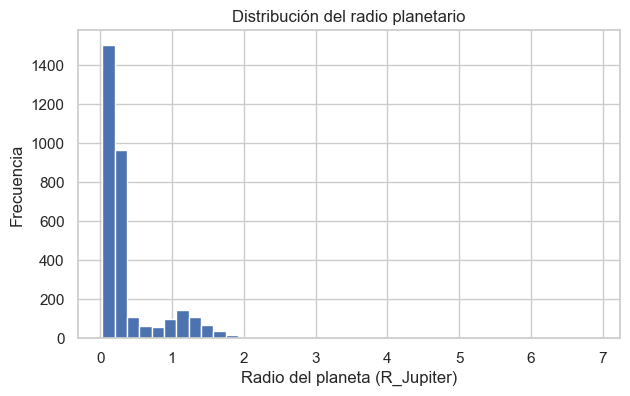

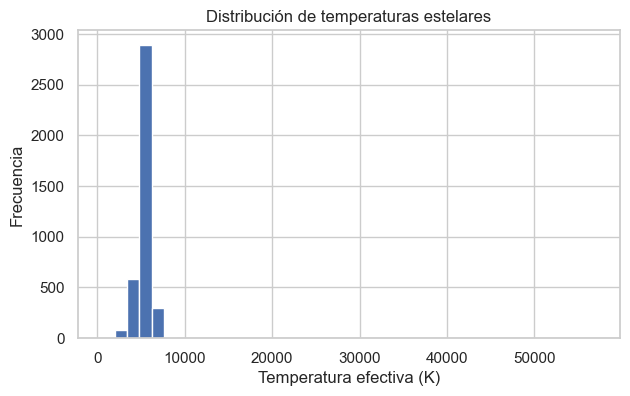

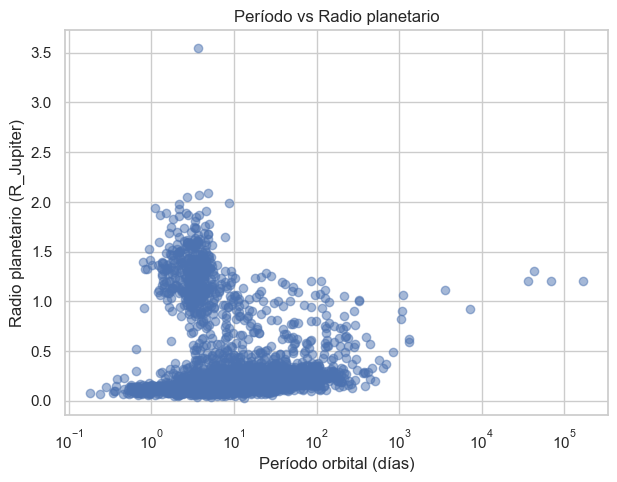

In [24]:
columnas_fisicas_recomendadas = [
    "pl_orbper", "pl_orbsmax", "pl_orbeccen", "pl_orbincl", "pl_bmassj", "pl_radj", "pl_dens", "st_teff", "st_mass", "st_rad", "st_dist", "st_optmag", 
]

columnas = [c for c in columnas_fisicas_recomendadas if c in df.columns]
print("Columnas físicas presentes:")
print(columnas)

df_phys = df[columnas].copy()
display(df_phys.describe())

#####
## COMPLETAR CON UN EDA MÁS PROFUNDO COMO HEMOS VISTO EN CLASE
## - Comprobar valores nulos por columna y comentarlos.
## - Hacer al menos: 1 histograma de una variable del planeta, 1 histograma de una variable de la estrella o 1 diagrama de dispersión (scatter) entre dos variables que te parezcan interesantes.
## - Comentar brevemente qué rangos de valores observas y si ves posibles outliers.

print("\nValores nulos por columna:")
print(df_phys.isnull().sum().sort_values(ascending=False))

print("\nPorcentajes de nulos:")
print((df_phys.isnull().mean().sort_values(ascending=False) * 100).round(2))

plt.figure(figsize=(7,4))
df_phys["pl_radj"].hist(bins=40)
plt.xlabel("Radio del planeta (R_Jupiter)")
plt.ylabel("Frecuencia")
plt.title("Distribución del radio planetario")
plt.show()

plt.figure(figsize=(7,4))
df_phys["st_teff"].hist(bins=40)
plt.xlabel("Temperatura efectiva (K)")
plt.ylabel("Frecuencia")
plt.title("Distribución de temperaturas estelares")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(df_phys["pl_orbper"], df_phys["pl_radj"], alpha=0.5)
plt.xlabel("Período orbital (días)")
plt.ylabel("Radio planetario (R_Jupiter)")
plt.title("Período vs Radio planetario")
plt.xscale("log")
plt.show()


### 3.2 Dispersión 2D (exploratoria)

Con las columnas físicas ya identificadas, el Comité Científico de la Estación Kepler te pide un **primer mapa 2D**
de los exoplanetas. La idea es simular la pantalla del **radar científico** de la patrulla: en cada eje colocarás
una magnitud física y observarás cómo se distribuyen los mundos.

En esta parte debes:

- Elegir **dos columnas** de `df_phys` (por ejemplo, periodo orbital vs masa, radio vs masa, etc.).
- Representar un **diagrama de dispersión (scatterplot)** para visualizar los exoplanetas.
- Utilizar **escala logarítmica** en ambos ejes (cuando tenga sentido físico) para ver mejor las nubes de puntos.
- Probar **al menos 3 combinaciones distintas** de pares de variables y anotar qué ves:
  - ¿Hay zonas con mucha concentración de puntos?
  - ¿Se intuyen grupos o “familias” de exoplanetas?
  - ¿Existen valores extremos (outliers) que podrían dar lugar a tipos muy raros?

> Piensa qué pares de variables pueden ayudarte a separar mejor los distintos tipos de exoplanetas.

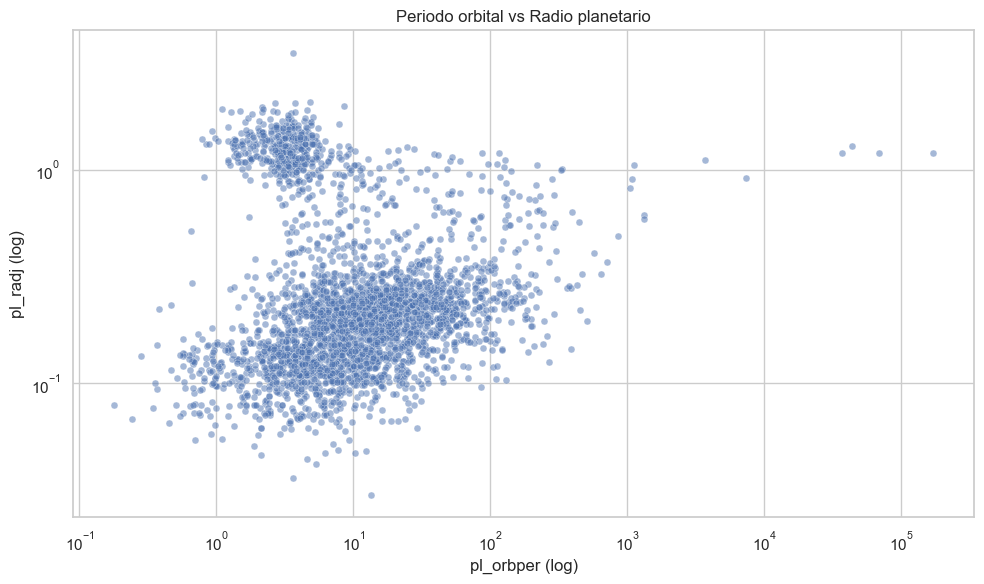

In [25]:
feature_x = "pl_orbper"   # cámbialo
feature_y = "pl_radj"    # cámbialo

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_phys, x=feature_x, y=feature_y, alpha=0.5, s=25)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(f"{feature_x} (log)")
plt.ylabel(f"{feature_y} (log)")
plt.title("Periodo orbital vs Radio planetario")
plt.tight_layout()
plt.show()

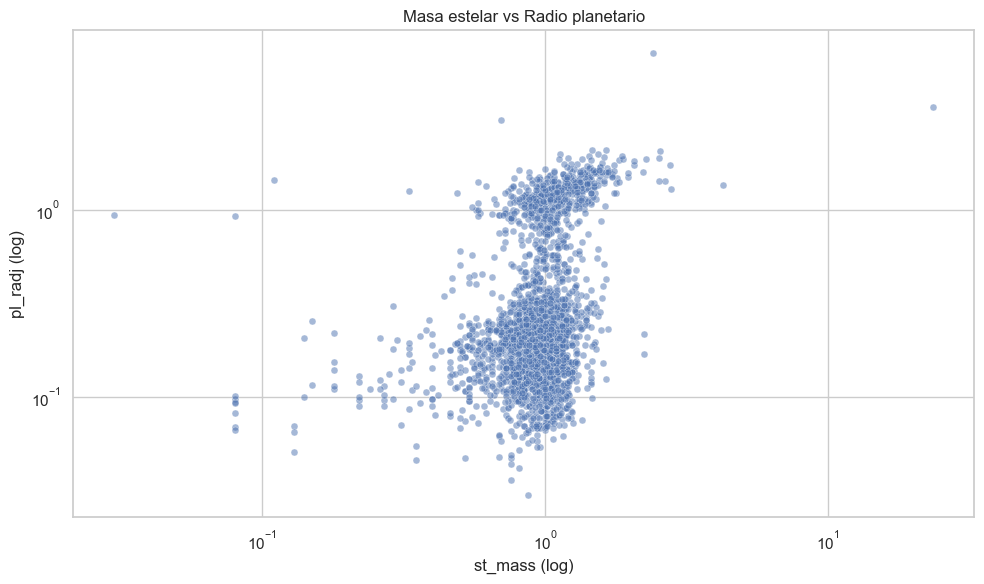

In [26]:
feature_x = "st_mass"
feature_y = "pl_radj"

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_phys, x=feature_x, y=feature_y, alpha=0.5, s=25)
plt.xscale("log"); plt.yscale("log")
plt.xlabel(f"{feature_x} (log)")
plt.ylabel(f"{feature_y} (log)")
plt.title("Masa estelar vs Radio planetario")
plt.tight_layout()
plt.show()

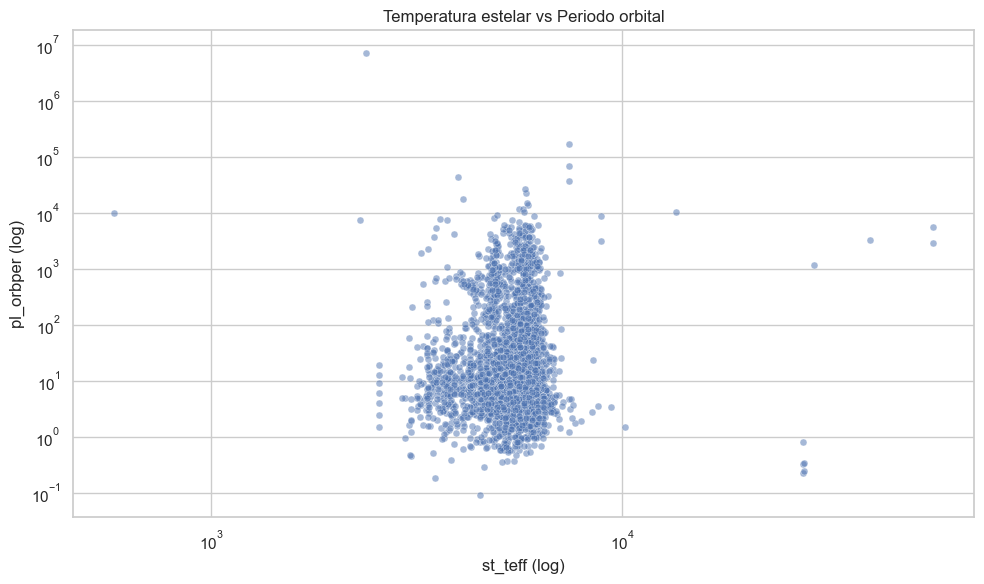

In [27]:
feature_x = "st_teff"
feature_y = "pl_orbper"

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_phys, x=feature_x, y=feature_y, alpha=0.5, s=25)
plt.xscale("log"); plt.yscale("log")
plt.xlabel(f"{feature_x} (log)")
plt.ylabel(f"{feature_y} (log)")
plt.title("Temperatura estelar vs Periodo orbital")
plt.tight_layout()
plt.show()


## 4. K-Means: descubrimiento de tipos de exoplanetas

### 4.1 Selección de variables para K-Means

El Comité Científico de la Estación Kepler ha decidido que, para esta primera misión, el algoritmo de agrupamiento
(K-Means) solo trabajará con un **panel reducido de sensores**. No tiene sentido lanzar todos los instrumentos a la vez:
cuantas más variables metamos, más difícil será interpretar después qué significa cada grupo.

Tu tarea en esta fase es:

- Elegir entre **2 y 4 columnas** de las variables físicas que has analizado en el EDA (`df_phys`).
- Comprobar rápidamente cómo son esos datos: rangos, posibles valores extremos y número de nulos.
- Crear un DataFrame reducido (`df_km`) que contenga **solo las filas** donde esas variables estén disponibles.

Piensa que lo que selecciones aquí será la “vista del universo” que tendrá K-Means.  
Si eliges mal los sensores, los tipos de exoplanetas que descubras podrían no tener ningún sentido físico.
Más adelante tendrás que **justificar en el informe** por qué escogiste esas variables.



Variables seleccionadas para K-Means: ['pl_orbper', 'pl_radj', 'st_teff']
Tamaño original (df_phys): (4126, 12)
Tamaño tras limpiar NaN para K-Means (df_km): (3093, 12)


,pl_orbper,pl_radj,st_teff
count,3093.000000,3093.000000,3093.000000
mean,131.513413,0.372789,5493.244853
std,3456.990811,0.408743,928.588340
min,0.179715,0.030000,2300.000000
25%,3.932461,0.140000,5145.000000
50%,8.689090,0.208000,5629.000000
75%,20.552802,0.317000,5954.000000
max,170000.000000,3.550000,27730.000000


Valores nulos en df_km (features seleccionadas):
pl_orbper    0
pl_radj      0
st_teff      0
dtype: int64


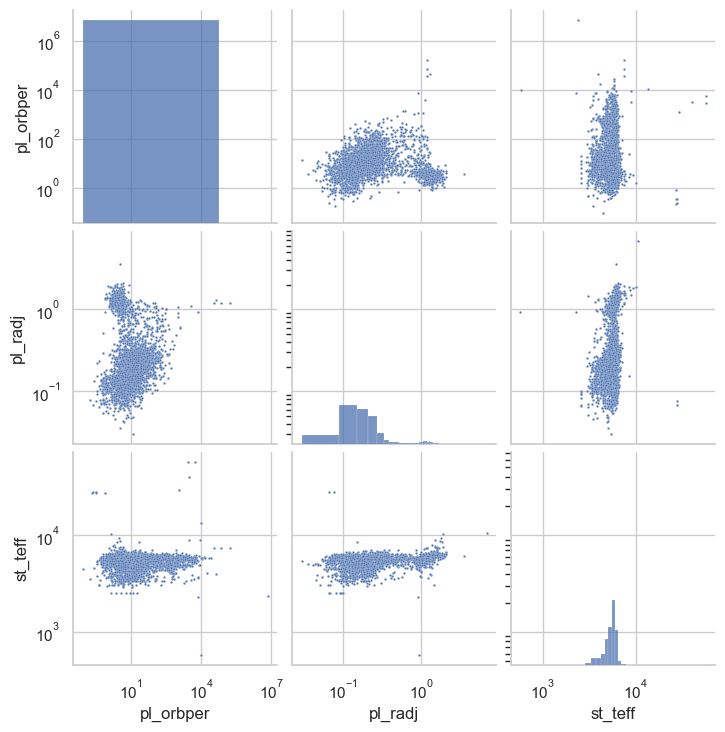

Percentiles 1% y 99% por variable:


,0.01,0.99
pl_orbper,0.664951,287.494393
pl_radj,0.066000,1.670480
st_teff,3360.352400,6820.480000


In [28]:
# Usa esta lista con las variables físicas que quieras usar en K-Means (deben estar dentro de `df_phys.columns`)
cols = ["pl_orbper", "pl_radj", "st_teff"]
features_kmeans = [c for c in cols if c in df_phys.columns]

print("Variables seleccionadas para K-Means:", features_kmeans)

# DataFrame reducido solo con las filas que tienen datos en TODAS esas columnas
df_km = df_phys.dropna(subset=features_kmeans).copy()

print("Tamaño original (df_phys):", df_phys.shape)
print("Tamaño tras limpiar NaN para K-Means (df_km):", df_km.shape)

# Resumen rápido de las variables elegidas
display(df_km[features_kmeans].describe())

#####
## TAREA – EDA 2.0 DE LAS VARIABLES ELEGIDAS:
## - Mostrar el número de valores nulos por columna en df_km (debería ser 0 en features_kmeans).
print("Valores nulos en df_km (features seleccionadas):")
print(df_km[features_kmeans].isnull().sum())
## - Dibujar al menos un histograma por cada variable seleccionada.
pp = sns.pairplot(df_phys, vars=cols, plot_kws={"s":3})
for ax in pp.axes.flat:
    if ax.get_xlabel() in cols:
        ax.set(xscale="log",yscale="log")
plt.show()
## - Comentar si hay rangos muy amplios o valores claramente extremos.
print("Percentiles 1% y 99% por variable:")
display(df_km[features_kmeans].quantile([0.01, 0.99]).T)
## - Añadir una breve conclusión en tu informe: ¿por qué crees que estas variables son buenas para que K-Means descubra tipos de exoplanetas?


### 4.2 Escalado y método del codo

Antes de lanzar el algoritmo K-Means, el ordenador central de la Estación Kepler-Σ te recuerda que los sensores no
miden todas las magnitudes en la misma escala: unas están en **días**, otras en **masas de Júpiter**, otras en
**radios solares**… Si no haces nada, las variables con números “grandes” dominarán la distancia y K-Means
ignorará las demás.

En esta fase vas a:

1. **Escalar** las variables seleccionadas con `StandardScaler`.
2. Probar varios valores de **K** (número de clusters) y calcular la **inercia** de K-Means.
3. Representar la inercia en función de K y buscar el famoso **“método del codo”**.

> En tu informe deberás **comentar la gráfica**:  
> – ¿Dónde ves el codo?  
> – ¿Qué valores de K te parecen razonables para describir tipos de exoplanetas?

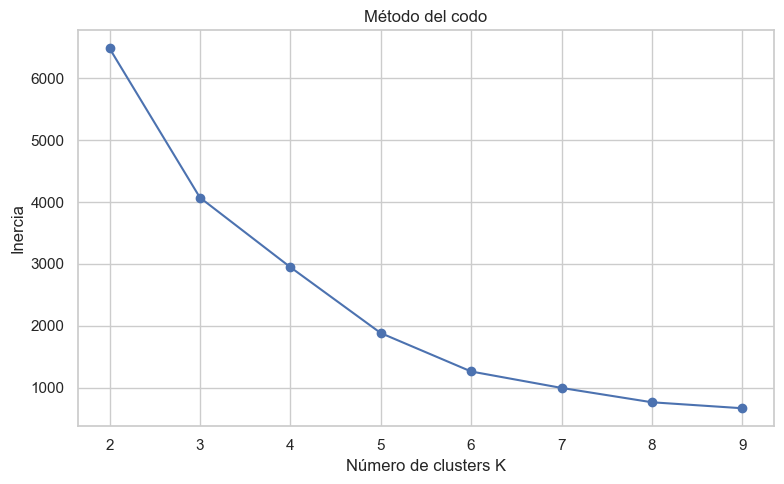

In [29]:
# Escalado de las variables seleccionadas para K-Means
scaler = StandardScaler()
X_km = df_km[features_kmeans].values
X_km_scaled = scaler.fit_transform(X_km)


# Cálculo de la inercia para varios valores de K
k_values = range(2, 10)
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_km_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_values), inertias, marker="o")
plt.xticks(list(k_values))
plt.xlabel("Número de clusters K")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.3 Entrenamiento final de K-Means y primera interpretación científica

Tras analizar la curva del codo, el Comité Científico de la Estación Kepler te pide que elijas un **valor concreto de K**
para esta misión. Ese será el número de “tipos provisionales de exoplanetas” que el ordenador central va a distinguir.

En esta fase debes:

1. Fijar un valor de `k_elegido` basándote en la gráfica del codo y en tu criterio científico.
2. Entrenar el modelo K-Means definitivo con ese K.
3. Asignar a cada exoplaneta el número de cluster correspondiente y contar **cuántos planetas hay en cada grupo**.
4. Empezar a interpretar los resultados:
   - ¿Hay clusters muy poblados y otros casi vacíos?
   - ¿Aparece algún cluster con muy pocos planetas (posibles **casos raros / outliers**)?
   - ¿Crees que todos los clusters deberían considerarse “tipos oficiales” o alguno es demasiado pequeño?

> Estas frecuencias serán clave más adelante, cuando uses estos clusters como etiquetas para entrenar el árbol de decisión y las SVM. 
> Un cluster con 1 solo planeta puede ser científicamente interesante, pero estadísticamente inestable.



In [30]:
k_elegido = 5
print("Usaremos K =", k_elegido)

kmeans_final = KMeans(n_clusters=k_elegido, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_km_scaled)

# Guardamos el número de cluster en el DataFrame
df_km["cluster_kmeans"] = clusters

print("\nFrecuencia de cada cluster:")
freq_clusters = df_km["cluster_kmeans"].value_counts().sort_index()
print(freq_clusters)

#####
# TAREA:
# - Copia estas frecuencias en tu informe y comenta:
#   * ¿Qué cluster es el más poblado? ¿Y el menos poblado?
#   * ¿Hay algún cluster con muy pocos exoplanetas?
# - Reflexiona: ¿tratarías esos clusters diminutos como tipos oficiales de planeta o como "mundos raros/outliers" que hay que analizar aparte? ¿Por qué?


Usaremos K = 5

Frecuencia de cada cluster:
cluster_kmeans
0    1940
1       1
2     507
3     643
4       2
Name: count, dtype: int64


### 4.4 Visualización 2D de los clusters (espacio original)

Ya tienes a cada exoplaneta asignado a un cluster de K-Means. El siguiente paso es pedirle al sistema de visualización
de la Estación Kepler un **mapa 2D coloreado por tipo**.

En esta vista:

- Los ejes X e Y serán dos de las variables físicas que has usado en K-Means.
- Cada punto es un exoplaneta.
- El color indica a qué **cluster** pertenece.

Tu objetivo es comprobar visualmente si K-Means ha encontrado grupos con cierta forma lógica (nubes compactas,
zonas separadas, etc.) y localizar posibles **mundos extremos** que se queden aislados.


Eje X: pl_radj
Eje Y: st_teff


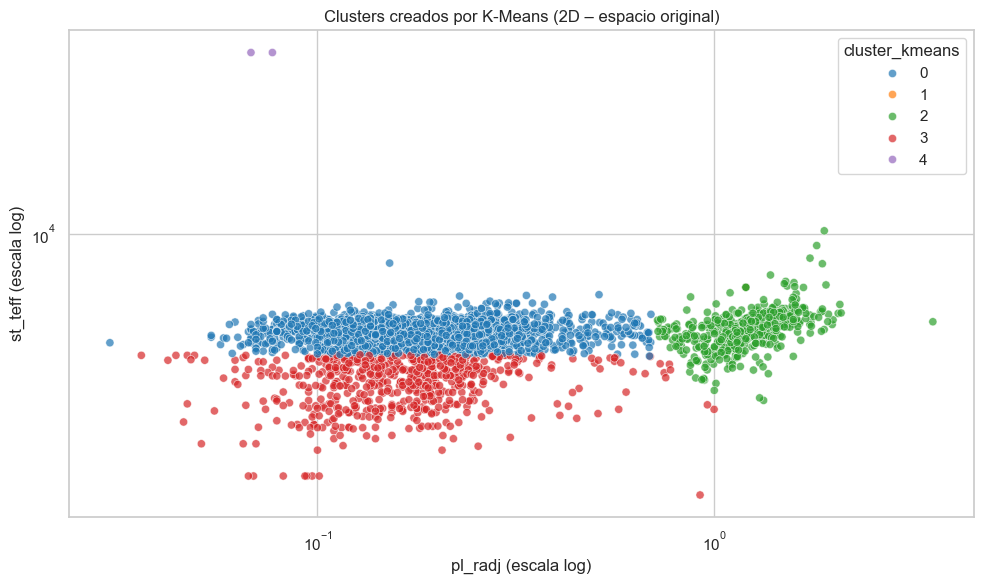

In [54]:
# Vista 2D – espacio original (valores sin escalar)
plot_x = features_kmeans[1]
plot_y = features_kmeans[2] if len(features_kmeans) > 1 else features_kmeans[0]

print("Eje X:", plot_x)
print("Eje Y:", plot_y)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_km,
    x=plot_x,
    y=plot_y,
    hue="cluster_kmeans",
    palette="tab10",
    s=35,
    alpha=0.7
)

# Escalas logarítmicas si tiene sentido físico
plt.xscale("log")
if plot_y != plot_x:
    plt.yscale("log")

plt.xlabel(f"{plot_x} (escala log)")
plt.ylabel(f"{plot_y} (escala log)")
plt.title("Clusters creados por K-Means (2D – espacio original)")
plt.tight_layout()
plt.show()

#####
# TAREA a comentar tu informe:
# - Cambia plot_x y plot_y para probar otras combinaciones de variables.
# - Comenta en tu informe si los clusters se ven bien separados o si se mezclan.
# - Señala si hay planetas muy alejados de los demás.

### 4.5 Visualización 3D de los clusters (espacio original)

El radar científico de la estación también permite una **vista tridimensional**. Si has utilizado al menos 3
variables en `features_kmeans`, puedes construir un mapa 3D donde:

- Cada eje corresponde a una de las variables físicas usadas en K-Means.
- Cada punto es un exoplaneta.
- El color indica el cluster asignado.

Esta vista sirve para comprobar si en tres dimensiones los grupos están aún más claros o si algunos clusters
se solapan cuando añades una variable extra.


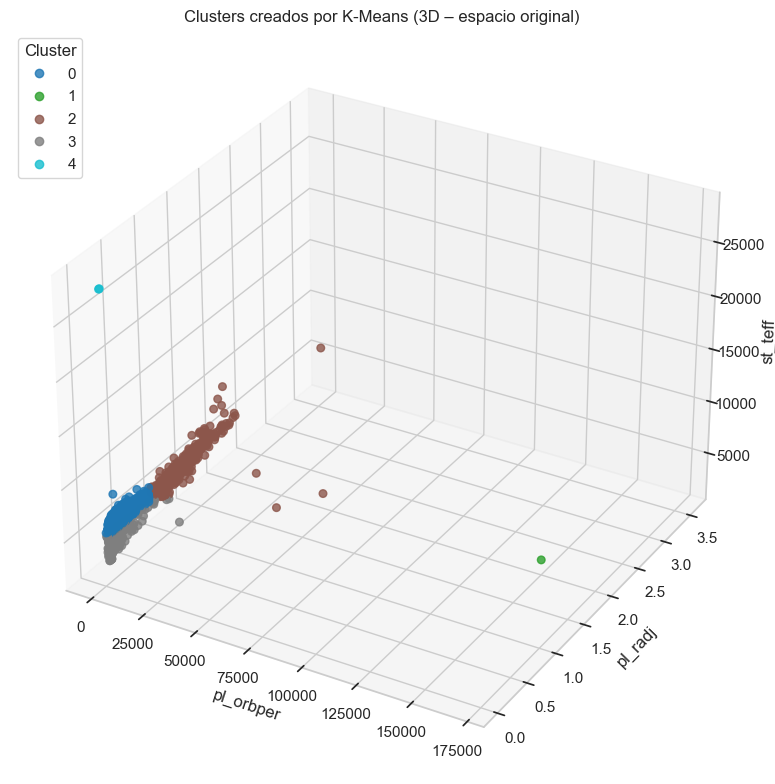

In [55]:
# Vista 3D – espacio original (sin escalar)

if len(features_kmeans) >= 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    x = df_km[features_kmeans[0]]
    y = df_km[features_kmeans[1]]
    z = df_km[features_kmeans[2]]
    c = df_km["cluster_kmeans"]

    scatter = ax.scatter(
        x, y, z,
        c=c,
        cmap="tab10",
        s=30,
        alpha=0.8
    )

    ax.set_xlabel(features_kmeans[0])
    ax.set_ylabel(features_kmeans[1])
    ax.set_zlabel(features_kmeans[2])
    ax.set_title("Clusters creados por K-Means (3D – espacio original)")

    handles, labels = scatter.legend_elements(prop="colors", alpha=0.8)
    ax.legend(handles, labels, title="Cluster", loc="upper left")

    plt.tight_layout()
    plt.show()
else:
    print("Necesitas al menos 3 variables en features_kmeans para la vista 3D.")

#####
# TAREA a comentar en tu informe:
# - Interpreta la vista 3D: ¿se distinguen mejor los tipos de exoplanetas que en 2D?
# - ¿Algún cluster parece muy extendido o mezclado con otros?

### 4.6 Visualización 3D de los clusters (espacio escalado)

Aunque las gráficas anteriores usan los valores físicos originales, K-Means ha trabajado realmente en el
**espacio escalado** (`X_km_scaled`).

En esta sección vas a visualizar los clusters en ese espacio escalado:

- Los ejes representan las versiones estandarizadas de las variables seleccionadas.
- No tienen unidades físicas directas, pero reflejan la “posición relativa” de cada planeta respecto a la media.

Esta vista te ayuda a entender **cómo “ve” el algoritmo** los exoplanetas, independientemente de sus unidades originales.

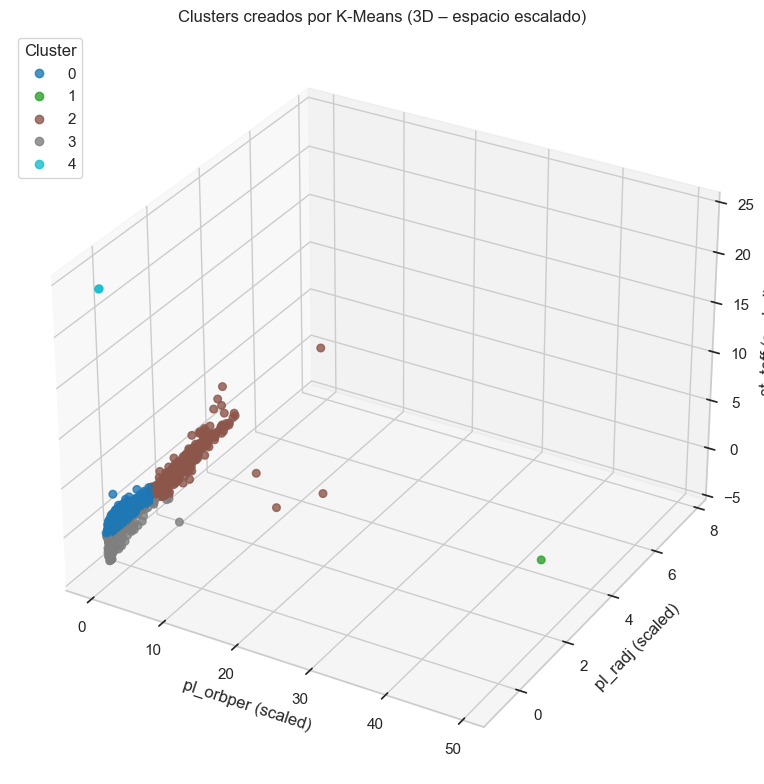

In [56]:
if len(features_kmeans) >= 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Usamos directamente las tres primeras columnas del array escalado
    x_scaled = X_km_scaled[:, 0]
    y_scaled = X_km_scaled[:, 1]
    z_scaled = X_km_scaled[:, 2]
    c = df_km["cluster_kmeans"].values

    scatter = ax.scatter(
        x_scaled, y_scaled, z_scaled,
        c=c,
        cmap="tab10",
        s=30,
        alpha=0.8
    )

    ax.set_xlabel(f"{features_kmeans[0]} (scaled)")
    ax.set_ylabel(f"{features_kmeans[1]} (scaled)")
    ax.set_zlabel(f"{features_kmeans[2]} (scaled)")
    ax.set_title("Clusters creados por K-Means (3D – espacio escalado)")

    handles, labels = scatter.legend_elements(prop="colors", alpha=0.8)
    ax.legend(handles, labels, title="Cluster", loc="upper left")

    plt.tight_layout()
    plt.show()
else:
    print("Necesitas al menos 3 variables en features_kmeans para la vista 3D escalada.")

#####
# TAREA:
# - Compara la vista 3D en espacio original y en espacio escalado.
# - ¿Cambian las formas de los grupos o simplemente la escala?
# - Explica en tu informe por qué el escalado es importante para K-Means,
#   aunque las visualizaciones físicas te resulten más intuitivas.


## 5. Diseño de la columna de clasificación

Hasta ahora K-Means solo te ha dado **números de cluster** (`0`, `1`, `2`, …) sin significado físico. 
El Comité Científico de la Estación Kepler quiere algo más útil: una **propuesta de taxonomía de exoplanetas** que pueda usarse en futuros informes y misiones.

Tu tarea en esta fase es convertir `cluster_kmeans` en una columna de **clasificación científica**,
que llamaremos `tipo_planeta`. Esta decisión es tuya:

- Asignar **nombres descriptivos** a cada cluster en función de lo que has visto en las gráficas y en función de las características propios de los exoplanetas.

> Lo importante es que tu `tipo_planeta` tenga **sentido físico** y que puedas justificarlo en tu informe:
> explica qué criterios has usado para nombrar/mezclar los clusters.


In [57]:
# 1) Filtrar outliers (clusters 1 y 4)
df_model = df_km[~df_km['cluster_kmeans'].isin([1, 4])].copy()

# 2) Mapa descriptivo
mapa_tipos = {
    0: "Sub-Neptuno caliente",
    2: "Hot-Júpiter compacto",
    3: "Júpiter templado"
}

if mapa_tipos:
    df_model["tipo_planeta"] = df_model["cluster_kmeans"].map(mapa_tipos)
else:
    df_model["tipo_planeta"] = df_model["cluster_kmeans"].astype(str)

print("Frecuencia de tipo_planeta:")
print(df_model["tipo_planeta"].value_counts())

#### TAREA:
### - Declarar el Diccionario nuevo de los planetas clasificados en el cluster y justificar su elección en el INFORME

Frecuencia de tipo_planeta:
tipo_planeta
Sub-Neptuno caliente    1940
Júpiter templado         643
Hot-Júpiter compacto     507
Name: count, dtype: int64


## 6. Preparación para modelos supervisados

En este punto vas a usar `tipo_planeta` como etiqueta para entrenar modelos supervisados
(árbol de decisión y SVM). Pero hay un problema potencial:

- Si alguno de los tipos de planeta tiene **muy pocas muestras** (por ejemplo, 1 solo planeta),
  el algoritmo `train_test_split` con `stratify=y` **no puede repartirlo** entre train y test y generará un error.

Esto suele ocurrir cuando K-Means crea un **cluster “apropiado” por un outlier**: un planeta rarísimo se queda totalmente solo en su cluster.

La tarea en esta sección es:

1. Ver las **frecuencias de `tipo_planeta`** y detectar tipos con muy pocas muestras.
2. Hacer un **primer intento de `train_test_split`** y observar el error, si existe.
3. Diseñar una estrategia para **eliminar o reagrupar** esos tipos raros antes de entrenar los modelos supervisados.


In [58]:
vc = df_model["tipo_planeta"].value_counts()
print("Frecuencia de cada tipo_planeta:")
print(vc)

X = df_model[features_kmeans].values
y = df_model["tipo_planeta"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Tamaño train:", X_train.shape[0])
print("Tamaño test :", X_test.shape[0])

#####
# TAREA:
# - Si este split te da error, copia el mensaje en tu informe y explica con tus palabras qué está pasando.
# - ¿Qué tipo(s) de planeta son los sospechosos?
# - Arregla el error para hacer una preparación correcta y deja reflejado en el informe cómo lo has hecho

Frecuencia de cada tipo_planeta:
tipo_planeta
Sub-Neptuno caliente    1940
Júpiter templado         643
Hot-Júpiter compacto     507
Name: count, dtype: int64
Tamaño train: 2163
Tamaño test : 927


Este es el error que obtendríamos si no filtramos los outliers:`ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.`. Optaré por filtrar los outliers antes de declarar el mapa de tipos.

## 7. Árbol de decisión – Autopiloto de clasificación

Hasta ahora, K-Means ha servido como **módulo de descubrimiento** a bordo de la Estación Kepler: ha creado tipos de
exoplanetas a partir de sus características físicas. Ahora el Comité quiere ir un paso más allá:

> Entrenar un **autopiloto de clasificación** capaz de predecir el `tipo_planeta` de un nuevo exoplaneta usando solo
> sus variables físicas.

Para ello usarás un **árbol de decisión**:

1. Probarás varias **profundidades** (`max_depth`) y compararás la `accuracy` de train y test.
2. Elegirás una profundidad “razonable” (no solo la que más acierta en test, sino la que tenga sentido).
3. Entrenarás un **árbol final** con esa profundidad.
4. Analizarás su **matriz de confusión** y comentarás dónde se equivoca.

Recuerda: estamos imitando la clasificación propuesta por K-Means. Si los clusters están muy bien separados, el árbol
podría llegar a reconstruirlos casi perfectamente… o sobreajustar si lo hacemos demasiado profundo.


In [45]:
# Lista de profundidades a probar
depths = [1,2,3,4,5,6,None]

train_scores = []
test_scores = []

print("max_depth | acc_train | acc_test")
print("-" * 32)

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)

    y_pred_tr = clf.predict(X_train)
    y_pred_te = clf.predict(X_test)

    acc_tr = accuracy_score(y_train, y_pred_tr)
    acc_te = accuracy_score(y_test, y_pred_te)

    train_scores.append(acc_tr)
    test_scores.append(acc_te)

    print(f"{str(d):>8} | {acc_tr:9.3f} | {acc_te:8.3f}")

#####
# TAREA:
# - Añade/quita valores en 'depths' y vuelve a ejecutar.
# - Observa cómo cambian las accuracies de train y test.
# - ¿Ves señales de sobreajuste (train muy alto y test bajando)?

max_depth | acc_train | acc_test
--------------------------------
       1 |     0.834 |    0.836
       2 |     0.998 |    0.998
       3 |     0.998 |    0.999
       4 |     1.000 |    1.000
       5 |     1.000 |    0.999
       6 |     1.000 |    0.999
    None |     1.000 |    0.999


### 7.1 - Curva profundidad vs accuracy

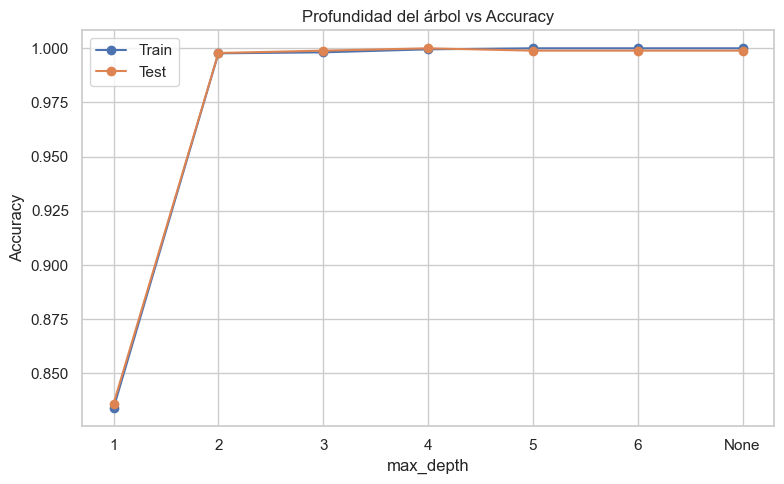

In [46]:
x_labels = [str(d) if d is not None else "None" for d in depths]

plt.figure(figsize=(8, 5))
plt.plot(range(len(depths)), train_scores, marker="o", label="Train")
plt.plot(range(len(depths)), test_scores, marker="o", label="Test")
plt.xticks(range(len(depths)), x_labels)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Profundidad del árbol vs Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_depth = 4

#####
# TAREA:
# - Mira la gráfica y el cuadro de valores anterior.
# - Elige MANUALMENTE una profundidad 'best_depth' que consideres razonable:
#   * ¿Te quedarías con la que más test tiene o con una un poco más simple pero con test similar?

### 7.2 - Entrenamiento del árbol

In [47]:
best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree.fit(X_train, y_train)

y_pred_train = best_tree.predict(X_train)
y_pred_test = best_tree.predict(X_test)

acc_tr_final = accuracy_score(y_train, y_pred_train)
acc_te_final = accuracy_score(y_test, y_pred_test)

print(f"Árbol final con max_depth = {best_depth}")
print(f"Accuracy (train): {acc_tr_final:.3f}")
print(f"Accuracy (test) : {acc_te_final:.3f}")

#####
# TAREA:
# - Justifica en tu informe por qué has elegido este 'best_depth' en lugar de otros posibles.
# - Comenta si el modelo parece estar sobreajustando o no.

Árbol final con max_depth = 4
Accuracy (train): 1.000
Accuracy (test) : 1.000


#### 7.2.1: Visualización del árbol: Figura

En este paso, inspeccionarás el **árbol de decisión final** como si fuera
el diagrama lógico del ordenador central de la Estación Kepler.

Queremos ver:

- Qué variables físicas aparecen en los primeros niveles.
- Qué umbrales usa el árbol para separar los tipos de exoplanetas.
- Si el árbol es relativamente sencillo o se ha convertido en una “selva” difícil de interpretar.

Para ello, dibujarás el árbol entrenado con `best_depth`.

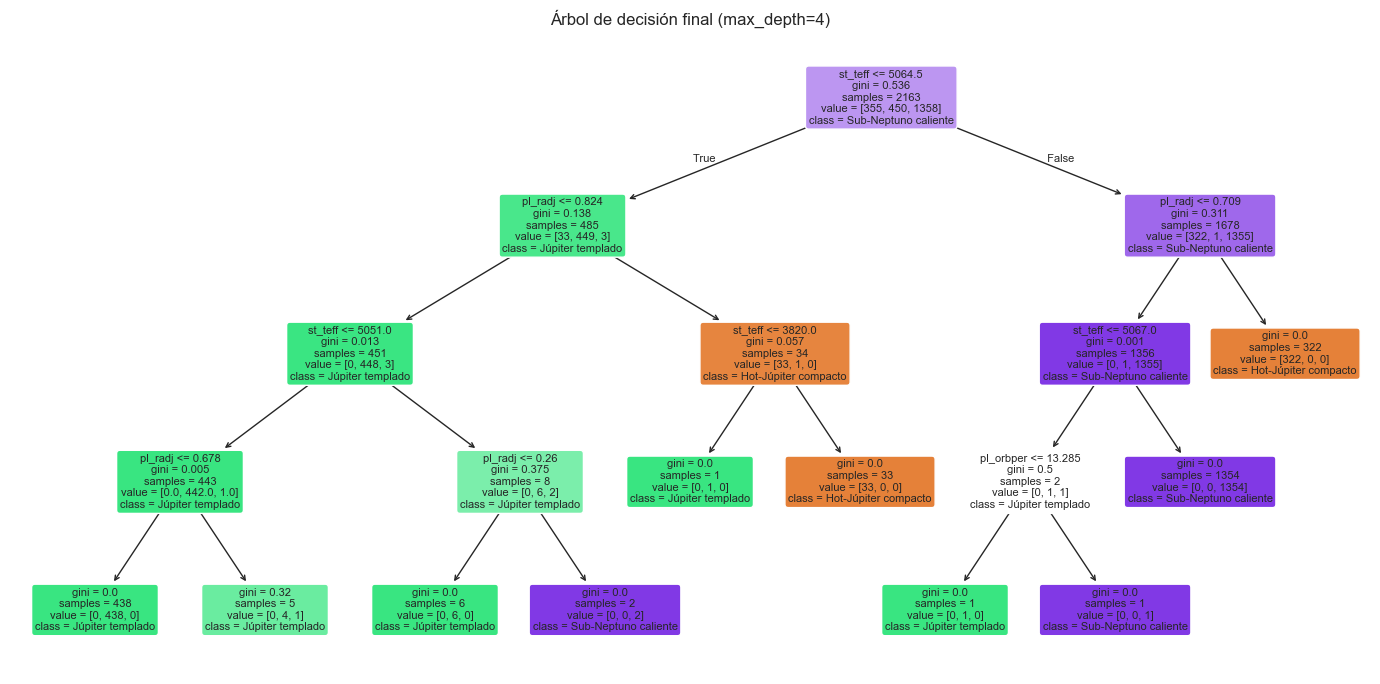

In [48]:
from sklearn.tree import plot_tree

#Los nombres de tus clases
class_names = best_tree.classes_

plt.figure(figsize=(14, 7))
plot_tree(
    best_tree,
    feature_names=features_kmeans,   # variables usadas como entrada del modelo
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title(f"Árbol de decisión final (max_depth={best_depth})")
plt.tight_layout()
plt.show()

#####
# TAREA:
# - Identifica qué variables aparecen en los primeros niveles del árbol.
# - Comenta si coinciden con tu intuición física (por ejemplo, ¿usa mucho la masa?).
# - Explica en tu informe, con palabras, una o dos ramas del árbol: “Si el periodo orbital es menor que X y la masa es mayor que Y, el sistema clasifica el planeta como tipo Z…”

#### 7.2.2: Visualización del árbol: Regiones 2D

Usaremos para la vista 2D:
  Eje X: pl_radj
  Eje Y: st_teff
Shape X_train_2d: (2163, 2)
Shape X_test_2d : (927, 2)


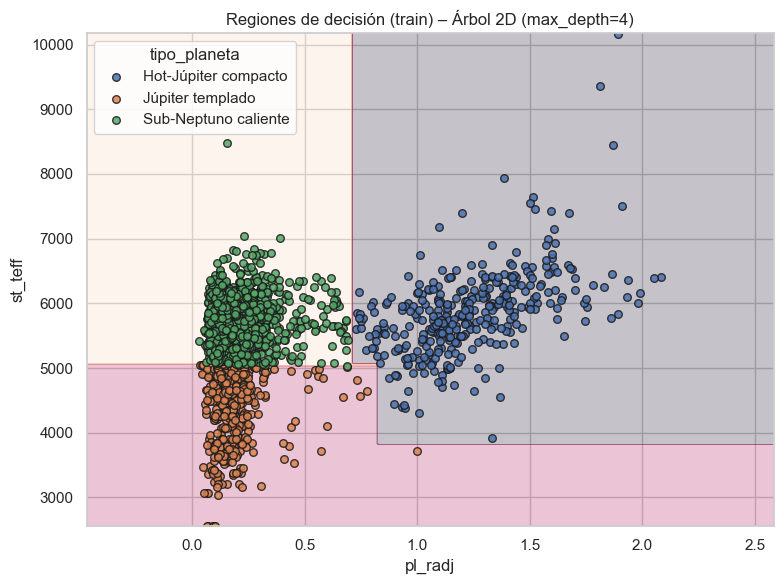

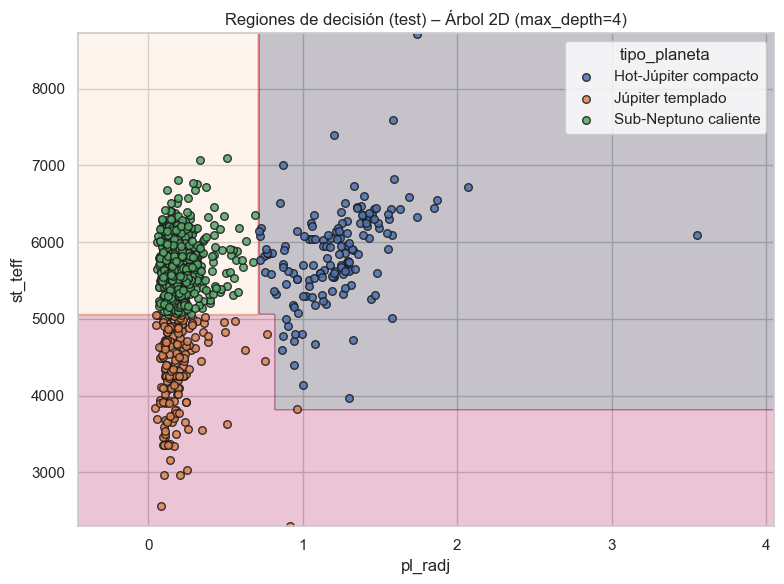

In [53]:
# 1) Elige las DOS características que quieres usar en 2D
#    Deben estar dentro de features_kmeans
FEAT_X = features_kmeans[1]   # Cámbialo si quieres usar otra variable en el eje X
FEAT_Y = features_kmeans[2]   # Cámbialo si quieres usar otra variable en el eje Y

print("Usaremos para la vista 2D:")
print("  Eje X:", FEAT_X)
print("  Eje Y:", FEAT_Y)

# Posiciones de esas columnas dentro de X_train / X_test
idx_x = features_kmeans.index(FEAT_X)
idx_y = features_kmeans.index(FEAT_Y)

# Creamos versiones 2D de los conjuntos
X_train_2d = X_train[:, [idx_x, idx_y]]
X_test_2d  = X_test[:,  [idx_x, idx_y]]

print("Shape X_train_2d:", X_train_2d.shape)
print("Shape X_test_2d :", X_test_2d.shape)


def plot_decision_regions_2d(model, X, y, feat_x_name, feat_y_name, title='Regiones de decisión'):
    """
    Dibuja las regiones de decisión de un clasificador en 2D (multiclase).
    """
    # Convertimos las etiquetas (posiblemente strings) a enteros para poder colorear
    clases = np.unique(y)
    mapa_clase_a_int = {cl: i for i, cl in enumerate(clases)}
    
    y_int = np.array([mapa_clase_a_int[cl] for cl in y])

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predicción sobre la rejilla
    Z = model.predict(grid)
    Z_int = np.array([mapa_clase_a_int[cl] for cl in Z]).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    # Fondo de regiones
    plt.contourf(xx, yy, Z_int, alpha=0.25)

    # Puntos reales
    for cl in clases:
        mask = (y == cl)
        plt.scatter(
            X[mask, 0],
            X[mask, 1],
            label=str(cl),
            edgecolor='k',
            alpha=0.85,
            s=30
        )

    plt.xlabel(feat_x_name)
    plt.ylabel(feat_y_name)
    plt.title(title)
    plt.legend(title="tipo_planeta")
    plt.tight_layout()
    plt.show()

# Entrenamos un árbol SOLO con las dos variables seleccionadas
tree_2d = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
tree_2d.fit(X_train_2d, y_train)

# Regiones de decisión en el conjunto de entrenamiento
plot_decision_regions_2d(
    tree_2d,
    X_train_2d,
    y_train,
    feat_x_name=FEAT_X,
    feat_y_name=FEAT_Y,
    title=f"Regiones de decisión (train) – Árbol 2D (max_depth={best_depth})"
)

# Regiones de decisión en el conjunto de test
plot_decision_regions_2d(
    tree_2d,
    X_test_2d,
    y_test,
    feat_x_name=FEAT_X,
    feat_y_name=FEAT_Y,
    title=f"Regiones de decisión (test) – Árbol 2D (max_depth={best_depth})"
)

#####
# TAREA:
# - Cambia FEAT_X y FEAT_Y para ver otras combinaciones de variables.
# - Compara visualmente las regiones en train y en test: ¿Ves fronteras muy retorcidas en train que luego no encajan bien en test? ¿Algún tipo de planeta queda en una “isla” pequeña rodeada de otros?
# - Explica en tu informe qué te dicen estas figuras sobre el comportamiento del autopiloto de clasificación.

### 7.3 - Matriz de confusión y análisis

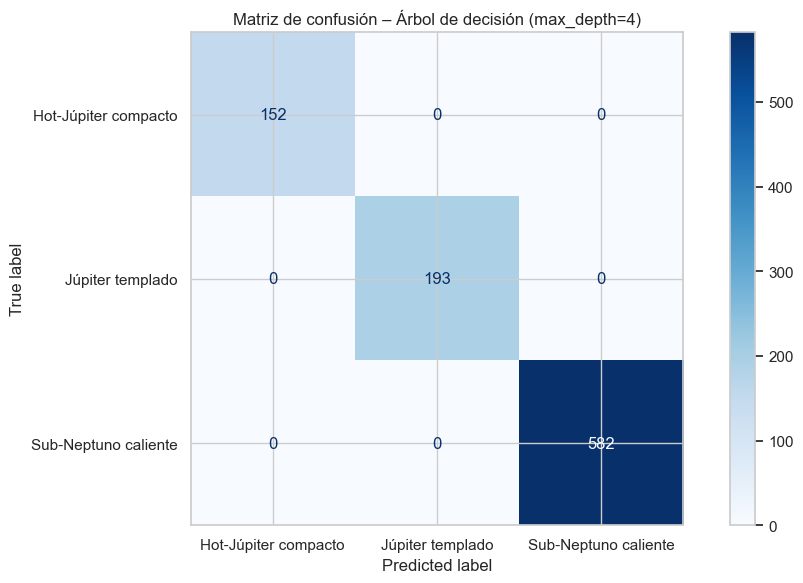

Matriz de confusión en porcentajes (por fila – clase real):
[[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]]

Informe de clasificación (precision, recall, f1 por tipo de planeta):
                      precision    recall  f1-score   support

Hot-Júpiter compacto      1.000     1.000     1.000       152
    Júpiter templado      1.000     1.000     1.000       193
Sub-Neptuno caliente      1.000     1.000     1.000       582

            accuracy                          1.000       927
           macro avg      1.000     1.000     1.000       927
        weighted avg      1.000     1.000     1.000       927



In [50]:
y_pred_best = best_tree.predict(X_test)
labels = sorted(np.unique(y_test))

cm = confusion_matrix(y_test, y_pred_best, labels=labels)

# Matriz de confusión en valores absolutos
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Matriz de confusión – Árbol de decisión (max_depth={best_depth})")
plt.tight_layout()
plt.show()

# Matriz de confusión en porcentajes por fila (respecto a la clase real)
cm_pct = cm / cm.sum(axis=1, keepdims=True)
cm_pct_round = np.round(cm_pct * 100, 2)

print("Matriz de confusión en porcentajes (por fila – clase real):")
print(cm_pct_round)

print("\nInforme de clasificación (precision, recall, f1 por tipo de planeta):")
print(classification_report(y_test, y_pred_best, digits=3))

#####
# TAREA:
# - Identifica qué tipos de planeta se confunden más entre sí.
# - ¿Hay algún tipo que el árbol casi nunca acierta o que casi siempre acierte?
# - Relaciona esto con lo que viste en los gráficos de K-Means ¿Esos tipos estaban cerca en el espacio de características?
# - Incluye en tu informe una breve discusión del tipo: “El autopiloto de clasificación de la Estación Kepler tiende a …”

## 8. SVM: kernels lineal, polinómico y RBF

El Comité de Navegación de la Estación Kepler-Σ quiere comparar el árbol de decisión con otro tipo de
autopiloto de clasificación: las **Máquinas de Vectores Soporte (SVM)**.

La idea es entrenar tres modelos distintos usando solo dos variables físicas
(`FEAT_X` y `FEAT_Y`, las mismas que has usado en las regiones de decisión del árbol):

- SVM con **kernel lineal**  
- SVM con **kernel polinómico**  
- SVM con **kernel RBF**  

Para cada kernel deberás:

1. Entrenar una SVM sobre el conjunto `X_train_2d, y_train`.
2. Calcular la **accuracy en test**.
3. Dibujar las **regiones de decisión** en train y en test.
4. Mostrar la **matriz de confusión** (normalizada por filas) y comentar sus errores.

> Tu objetivo es decidir cuál de los tres kernels se comporta mejor como autopiloto de clasificación de
> exoplanetas en este espacio 2D, y explicar **por qué crees que ese kernel funciona mejor o peor**
> (fronteras lineales vs curvas, sobreajuste, etc.).




SVM con kernel = linear
Accuracy en test: 0.994

Informe de clasificación:
                      precision    recall  f1-score   support

Hot-Júpiter compacto      0.987     0.980     0.983       152
    Júpiter templado      0.995     0.990     0.992       193
Sub-Neptuno caliente      0.995     0.998     0.997       582

            accuracy                          0.994       927
           macro avg      0.992     0.989     0.991       927
        weighted avg      0.994     0.994     0.994       927



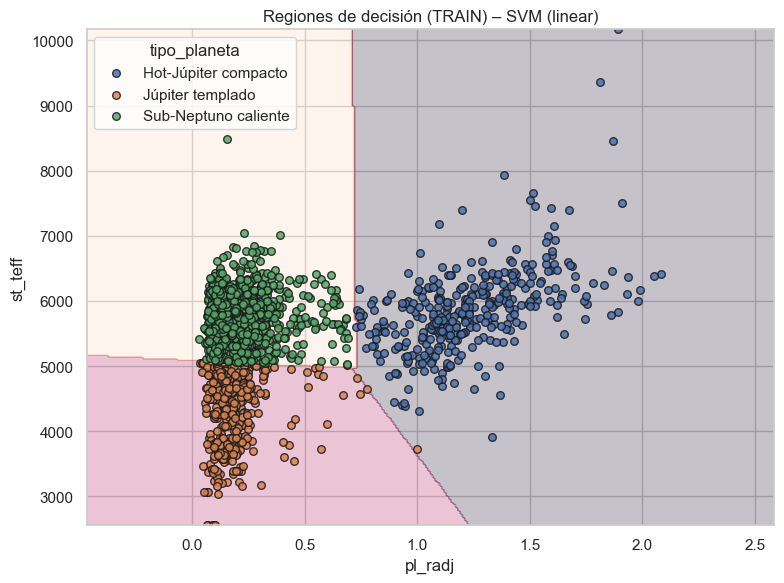

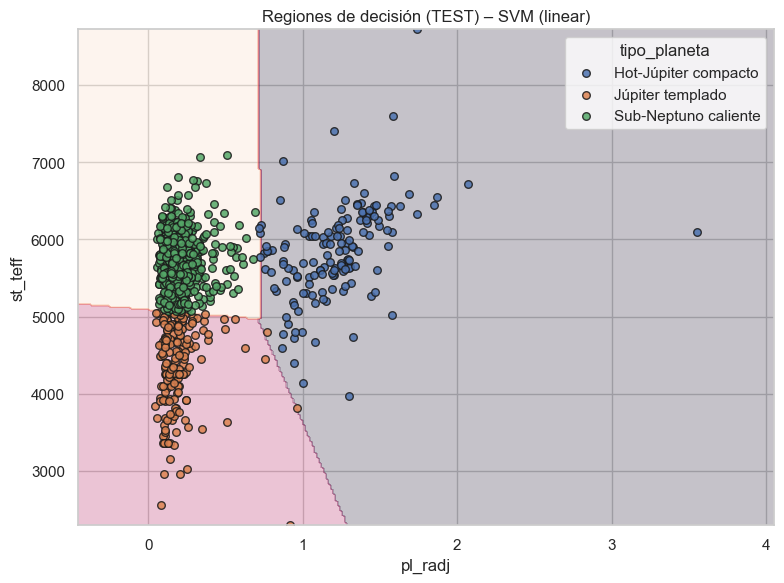

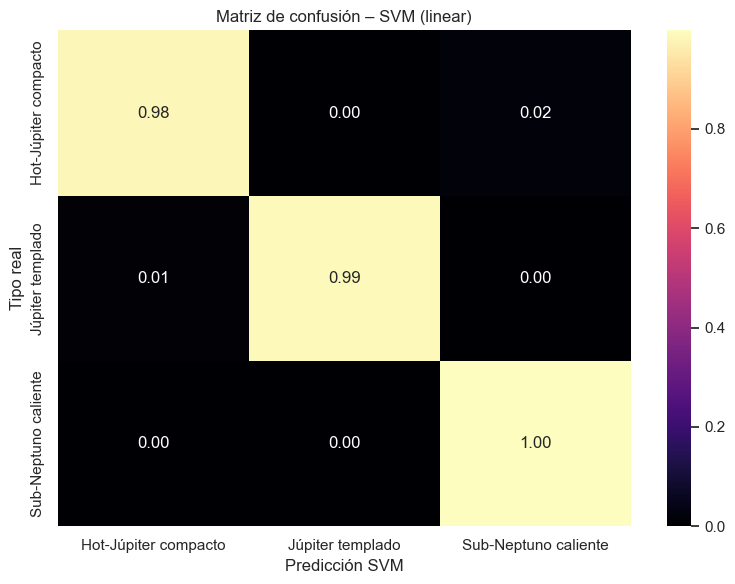


SVM con kernel = poly
Accuracy en test: 0.961

Informe de clasificación:
                      precision    recall  f1-score   support

Hot-Júpiter compacto      1.000     0.961     0.980       152
    Júpiter templado      1.000     0.845     0.916       193
Sub-Neptuno caliente      0.942     1.000     0.970       582

            accuracy                          0.961       927
           macro avg      0.981     0.935     0.955       927
        weighted avg      0.963     0.961     0.960       927



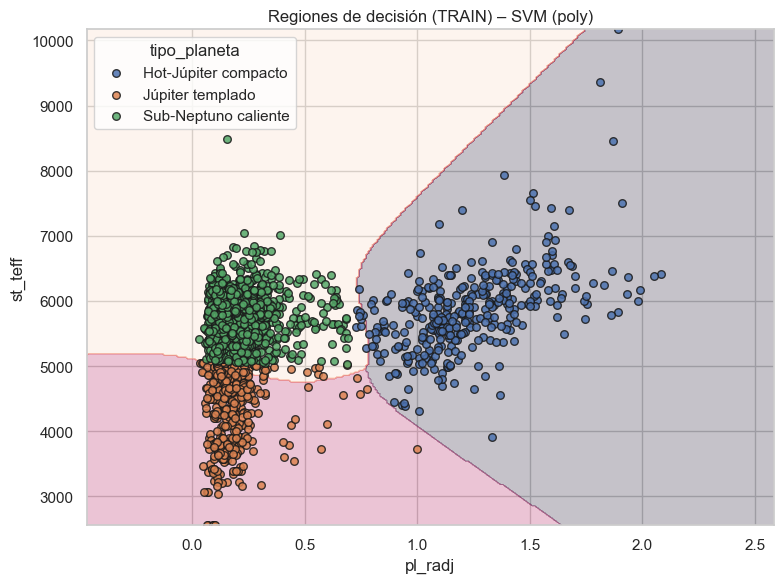

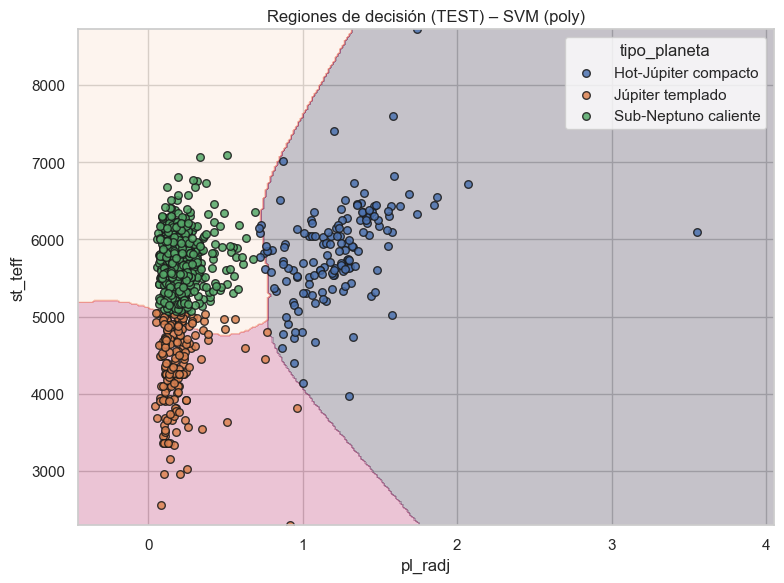

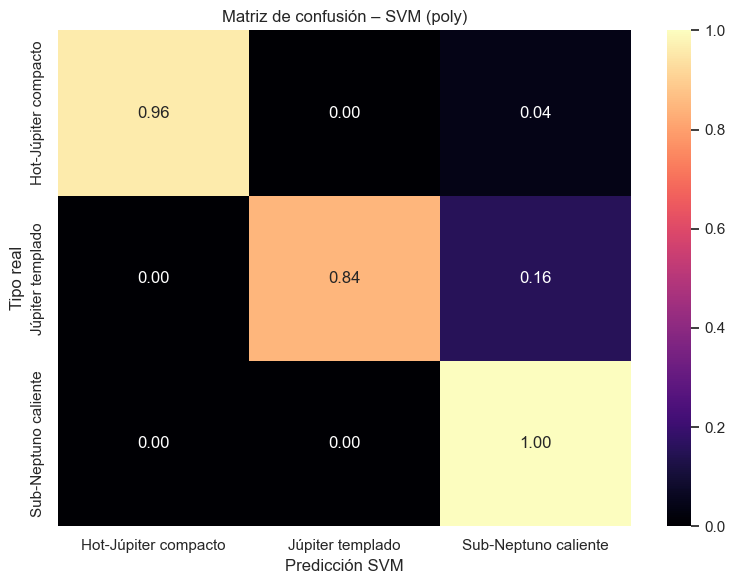


SVM con kernel = rbf
Accuracy en test: 0.998

Informe de clasificación:
                      precision    recall  f1-score   support

Hot-Júpiter compacto      0.993     1.000     0.997       152
    Júpiter templado      0.995     1.000     0.997       193
Sub-Neptuno caliente      1.000     0.997     0.998       582

            accuracy                          0.998       927
           macro avg      0.996     0.999     0.997       927
        weighted avg      0.998     0.998     0.998       927



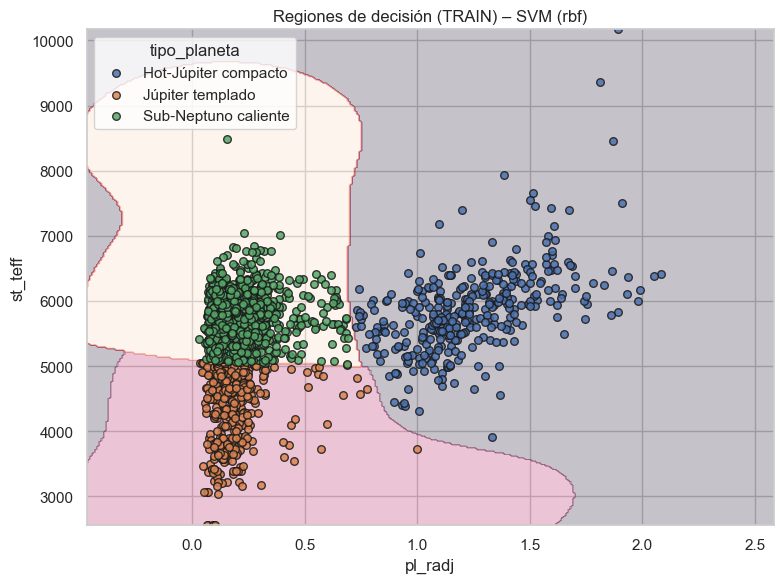

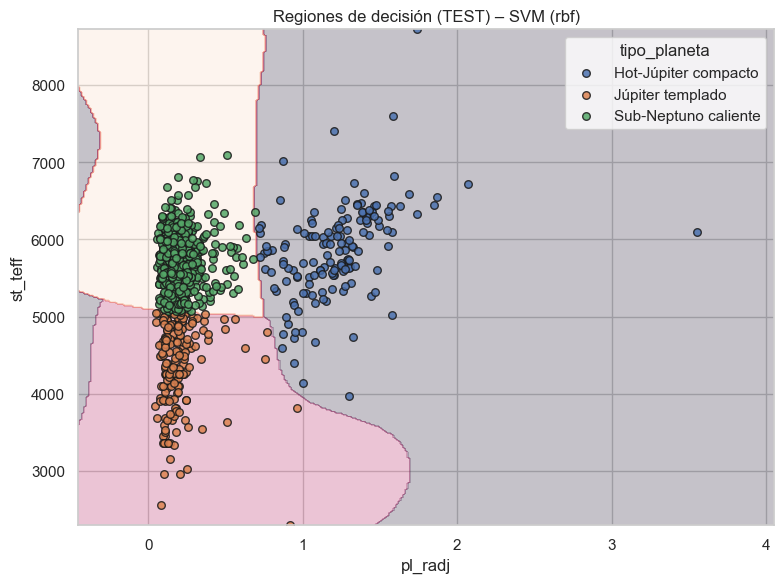

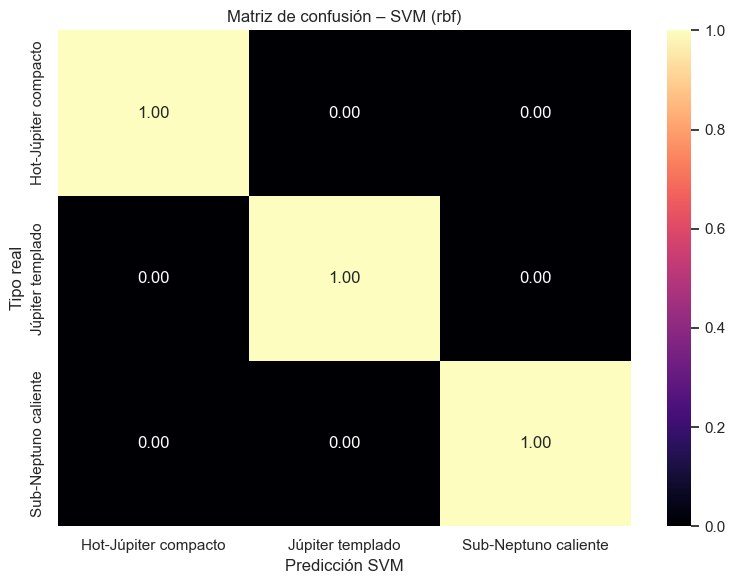


Resumen de accuracy en test por kernel:
- linear: 0.994
- poly  : 0.961
- rbf   : 0.998


In [60]:
# Declara los kernels
kernels = ["linear", "poly", "rbf"]
resultados_svm = {}

# Orden de etiquetas para las matrices de confusión
labels = sorted(np.unique(y_test))

for kernel in kernels:
    print("\n" + "=" * 70)
    print(f"SVM con kernel = {kernel}")
    print("=" * 70)

    # Pipeline: escalado + SVM
    # Cambia C, degree o gamma
    if kernel == "linear":
        svm_clf = make_pipeline(StandardScaler(),
                                SVC(kernel=kernel, C=1.0, random_state=42))
    elif kernel == "poly":
        svm_clf = make_pipeline(StandardScaler(),
                                SVC(kernel=kernel, degree=5, C=3.0, gamma="scale", random_state=42))
    else:  # rbf
        svm_clf = make_pipeline(StandardScaler(),
                                SVC(kernel=kernel, C=10, gamma="scale", random_state=42))

    # Entrenamos usando solo las dos variables elegidas (vista 2D)
    svm_clf.fit(X_train_2d, y_train)

    # Predicción en test
    y_pred = svm_clf.predict(X_test_2d)
    acc = accuracy_score(y_test, y_pred)
    resultados_svm[kernel] = acc

    print(f"Accuracy en test: {acc:.3f}")
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred, digits=3))

    # Regiones de decisión en el conjunto de entrenamiento
    plot_decision_regions_2d(
        svm_clf,
        X_train_2d,
        y_train,
        feat_x_name=FEAT_X,
        feat_y_name=FEAT_Y,
        title=f"Regiones de decisión (TRAIN) – SVM ({kernel})"
    )

    # Regiones de decisión en el conjunto de test
    plot_decision_regions_2d(
        svm_clf,
        X_test_2d,
        y_test,
        feat_x_name=FEAT_X,
        feat_y_name=FEAT_Y,
        title=f"Regiones de decisión (TEST) – SVM ({kernel})"
    )

    # Matriz de confusión normalizada por filas
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="magma",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Predicción SVM")
    plt.ylabel("Tipo real")
    plt.title(f"Matriz de confusión – SVM ({kernel})")
    plt.tight_layout()
    plt.show()

# Resumen final
print("\nResumen de accuracy en test por kernel:")
for k, v in resultados_svm.items():
    print(f"- {k:6s}: {v:.3f}")

#####
# TAREAS:
# 1) Cambia FEAT_X y FEAT_Y para probar otros pares de variables físicas.
# 2) Vuelve a ejecutar esta celda y compara cómo cambian las fronteras y las matrices de confusión.
# 3) Prueba a modificar C, degree (para 'poly') o gamma (para 'rbf') en la definición de SVC.
# 4) En tu informe responde:
#    - ¿Qué kernel funciona mejor en tu escenario? ¿Por qué?
#    - ¿Qué kernel parece sobreajustar más (fronteras muy retorcidas, errores raros en test, etc)?
#    - ¿Tiene sentido físico el tipo de frontera que dibuja cada kernel para separar los tipos de exoplanetas?

## 9. Guía para el informe en Word

En el informe final deberías incluir, al menos:

1. **Objetivo y contexto**: misión científica y qué quieres conseguir.
2. **Selección de variables**: qué columnas has usado y por qué.
3. **K-Means**: elección de K, interpretación de cada cluster, posibles outliers.
4. **Árbol de decisión**: profundidad elegida, comparación train/test, matriz de confusión.
5. **SVM**: comparación entre kernels (linear, poly, rbf). ¿Cuál se ajusta mejor y por qué?
6. **Conclusiones**: qué has aprendido sobre los tipos de exoplanetas y sobre las diferencias entre aprendizaje no supervisado y supervisado.
